In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
os.chdir('/content/drive/MyDrive/Signature_Verification/Data')

In [ ]:
!ls

test_data  train_data  validation_data


In [ ]:
def get_data(dir, labels):
    features = []
    targets = []
    for name in tqdm(sorted(os.listdir(dir))):
        for image_name in sorted(os.listdir(dir+'/'+name)):
            img = cv2.imread(dir+'/'+name+'/'+image_name)#, cv2.IMREAD_GRAYSCALE)
            features.append(img)
            if labels:
                if 'forg' in name.lower():
                    targets.append(1)
                else:
                    targets.append(0)
    if labels:
        return np.array(features),np.array(targets)
    else:
        return np.array(features)

In [ ]:
train_features, train_labels = get_data('train_data', True)
validation_features, validation_labels = get_data('validation_data', True)
test_features, test_labels = get_data('test_data', True)

100%|██████████| 14/14 [00:00<00:00, 15.34it/s]


In [ ]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(1010, 268, 650, 3)
(140, 268, 650, 3)
(140, 268, 650, 3)


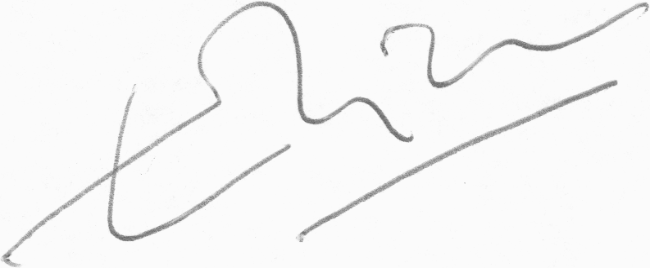

In [ ]:
cv2_imshow(train_features[4])

In [ ]:
train_features = train_features.astype('float32') / 255
validation_features = validation_features.astype('float32') / 255
test_features = test_features.astype('float32') / 255

In [ ]:
from keras.applications import VGG19

# Load the VGG19 model without the top layer (fully connected layers)
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(268, 650, 3))

# Freeze all layers of the convolutional base
for layer in conv_base.layers:
    layer.trainable = False


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from keras import layers
from keras import models
from keras import optimizers

end_model = models.Sequential()
end_model.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))
end_model.add(layers.Dense(64, activation='relu'))
end_model.add(layers.Dense(64, activation='relu'))
end_model.add(layers.Dense(1, activation='sigmoid'))

model = models.Model(inputs=conv_base.input, outputs=end_model(conv_base.output))
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(train_features, train_labels, epochs=20, batch_size=16, validation_data=(validation_features, validation_labels))

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 623ms/step - accuracy: 0.6079 - loss: 0.6667 - val_accuracy: 0.6000 - val_loss: 0.6726
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 303ms/step - accuracy: 0.6350 - loss: 0.6316 - val_accuracy: 0.6071 - val_loss: 0.6549
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - accuracy: 0.6745 - loss: 0.6054 - val_accuracy: 0.6071 - val_loss: 0.6381
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.7102 - loss: 0.5844 - val_accuracy: 0.6929 - val_loss: 0.6240
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.7707 - loss: 0.5592 - val_accuracy: 0.7357 - val_loss: 0.6107
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.7852 - loss: 0.5491 - val_accuracy: 0.7500 - val_loss: 0.5957
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.8418 - loss: 0.5192 - val_accuracy: 0.6286 - val_loss: 0.5981
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.8140 - loss: 0.4936 - val_accu

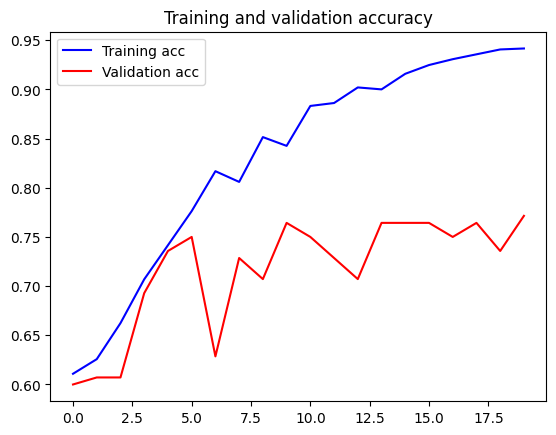

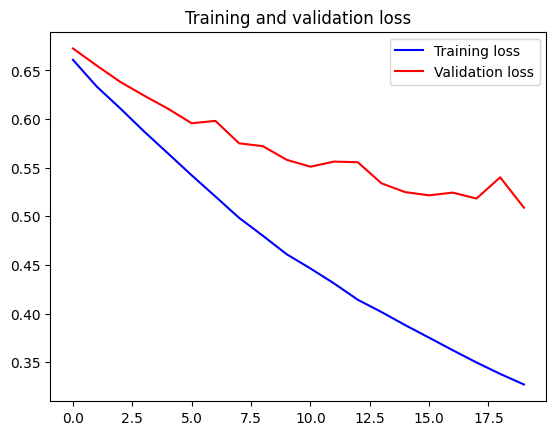

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
test_acc

5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 505ms/step - accuracy: 0.9395 - loss: 0.3913


0.9071428775787354

In [ ]:
model.save('signature_forgery_vgg19.h5')